# House Prices Prediciton

## Imports

In [452]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col

from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StringIndexer
from pyspark.ml.pipeline import Pipeline
from pyspark.ml.regression import LinearRegression


from sklearn import tree
from sklearn.tree import _tree
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix

# import data field types
from pyspark.sql.types import StringType, DoubleType,\
IntegerType, StructType, StructField, FloatType
from pyspark.sql.functions import isnan, when, count, col, mean, max

import pandas as pd
import seaborn as sns
import numpy as np  
import matplotlib.pyplot as plt  
import seaborn as seabornInstance 
from sklearn.model_selection import train_test_split 
from sklearn import metrics

## Initialization

In [453]:
spark = SparkSession.builder.getOrCreate()

In [454]:
path = "./Master2/house-prices-prediction/train.csv"

sdf = spark.read.csv(path,header=True,inferSchema=True)

In [455]:
pdf = pd.read_csv(path)

# Data analyse

In [456]:
sdf.limit(5).toPandas()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65,8450,Pave,NA,Reg,Lvl,AllPub,...,0,NA,NA,NA,0,2,2008,WD,Normal,208500
1,2,20,RL,80,9600,Pave,NA,Reg,Lvl,AllPub,...,0,NA,NA,NA,0,5,2007,WD,Normal,181500
2,3,60,RL,68,11250,Pave,NA,IR1,Lvl,AllPub,...,0,NA,NA,NA,0,9,2008,WD,Normal,223500
3,4,70,RL,60,9550,Pave,NA,IR1,Lvl,AllPub,...,0,NA,NA,NA,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84,14260,Pave,NA,IR1,Lvl,AllPub,...,0,NA,NA,NA,0,12,2008,WD,Normal,250000


In [457]:
sdf.dtypes

[('Id', 'int'),
 ('MSSubClass', 'int'),
 ('MSZoning', 'string'),
 ('LotFrontage', 'string'),
 ('LotArea', 'int'),
 ('Street', 'string'),
 ('Alley', 'string'),
 ('LotShape', 'string'),
 ('LandContour', 'string'),
 ('Utilities', 'string'),
 ('LotConfig', 'string'),
 ('LandSlope', 'string'),
 ('Neighborhood', 'string'),
 ('Condition1', 'string'),
 ('Condition2', 'string'),
 ('BldgType', 'string'),
 ('HouseStyle', 'string'),
 ('OverallQual', 'int'),
 ('OverallCond', 'int'),
 ('YearBuilt', 'int'),
 ('YearRemodAdd', 'int'),
 ('RoofStyle', 'string'),
 ('RoofMatl', 'string'),
 ('Exterior1st', 'string'),
 ('Exterior2nd', 'string'),
 ('MasVnrType', 'string'),
 ('MasVnrArea', 'string'),
 ('ExterQual', 'string'),
 ('ExterCond', 'string'),
 ('Foundation', 'string'),
 ('BsmtQual', 'string'),
 ('BsmtCond', 'string'),
 ('BsmtExposure', 'string'),
 ('BsmtFinType1', 'string'),
 ('BsmtFinSF1', 'int'),
 ('BsmtFinType2', 'string'),
 ('BsmtFinSF2', 'int'),
 ('BsmtUnfSF', 'int'),
 ('TotalBsmtSF', 'int'),
 ('

In [458]:
pdf.shape

(1460, 81)

# Preprocessing : clean code 

## Filter null values

In [459]:
# vérifier les valeurs nulles
pdf.isnull().sum().sort_values(ascending=False)

PoolQC         1453
MiscFeature    1406
Alley          1369
Fence          1179
FireplaceQu     690
               ... 
ExterQual         0
Exterior2nd       0
Exterior1st       0
RoofMatl          0
SalePrice         0
Length: 81, dtype: int64

In [460]:
sdf.select([count(when(col(c) == 'NA', c)).alias(c) for c in sdf.columns]).show()

+---+----------+--------+-----------+-------+------+-----+--------+-----------+---------+---------+---------+------------+----------+----------+--------+----------+-----------+-----------+---------+------------+---------+--------+-----------+-----------+----------+----------+---------+---------+----------+--------+--------+------------+------------+----------+------------+----------+---------+-----------+-------+---------+----------+----------+--------+--------+------------+---------+------------+------------+--------+--------+------------+------------+-----------+------------+----------+----------+-----------+----------+-----------+------------+----------+----------+----------+----------+----------+----------+-----------+-------------+---------+-----------+--------+------+-----+-----------+-------+------+------+--------+-------------+---------+
| Id|MSSubClass|MSZoning|LotFrontage|LotArea|Street|Alley|LotShape|LandContour|Utilities|LotConfig|LandSlope|Neighborhood|Condition1|Condition

<AxesSubplot:>

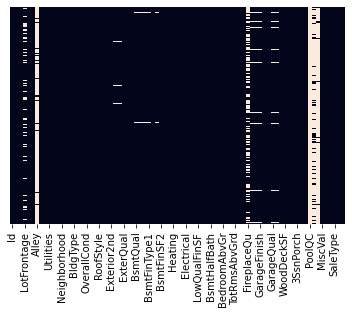

In [461]:
sns.heatmap(pdf.isnull(),yticklabels=False,cbar=False)

In [462]:
sdf = sdf.drop(*['Id', 'Alley','GarageYrBlt','PoolQC','Fence','MiscFeature'])

In [463]:
sdf.toPandas().shape

(1460, 75)

In [464]:
def df_fillna(sdf, value: str, subset: str):
    return sdf.withColumn(subset, when(sdf[subset] == "NA",value) \
      .otherwise(sdf[subset]))

In [465]:
#Le mode d'un ensemble de valeurs est la valeur qui apparaît le plus souvent. Il peut s'agir de plusieurs valeurs
def mode(name: str) -> str:
    mode = sdf.join(
        sdf.filter(sdf.GarageType != "NA").agg(max(name).alias("max_")), col(name) == col("max_")
    ).limit(1).select(name)

    return mode.first()[0]

In [466]:
#return the average from the height column
LotFrontage_mean = sdf.select(mean('LotFrontage')).collect()[0]
sdf = df_fillna(sdf, LotFrontage_mean["avg(LotFrontage)"], "LotFrontage")

In [467]:
sdf = df_fillna(sdf, value=mode(name="BsmtCond"), subset="BsmtCond")
sdf = df_fillna(sdf, value=mode(name="BsmtQual"), subset="BsmtQual")

In [468]:
sdf = df_fillna(sdf, value=mode(name="GarageType"), subset="GarageType")
sdf = df_fillna(sdf, value=mode(name="FireplaceQu"), subset="FireplaceQu")

In [469]:
sdf = df_fillna(sdf, value=mode(name="GarageFinish"), subset="GarageFinish")
sdf = df_fillna(sdf, value=mode(name="GarageQual"), subset="GarageQual")
sdf = df_fillna(sdf, value=mode(name="GarageCond"), subset="GarageCond")

In [470]:
mean_MasVnrArea = sdf.select(mean('MasVnrArea')).collect()[0]
sdf = df_fillna(sdf, mean_MasVnrArea["avg(MasVnrArea)"], "MasVnrArea")

In [471]:
sdf = df_fillna(sdf, value=mode(name="MasVnrType"), subset="MasVnrType")
sdf = df_fillna(sdf, value=mode(name="MasVnrArea"), subset="MasVnrArea")

In [472]:
sdf = df_fillna(sdf, value=mode(name="BsmtExposure"), subset="BsmtExposure")

In [473]:
sdf = df_fillna(sdf, value=mode(name="BsmtFinType1"), subset="BsmtFinType1")
sdf = df_fillna(sdf, value=mode(name="BsmtFinType2"), subset="BsmtFinType2")

In [474]:
sdf = df_fillna(sdf, value=mode(name="Electrical"), subset="Electrical")

In [475]:
sdf.select([count(when(col(c) == 'NA', c)).alias(c) for c in sdf.columns]).show()

+----------+--------+-----------+-------+------+--------+-----------+---------+---------+---------+------------+----------+----------+--------+----------+-----------+-----------+---------+------------+---------+--------+-----------+-----------+----------+----------+---------+---------+----------+--------+--------+------------+------------+----------+------------+----------+---------+-----------+-------+---------+----------+----------+--------+--------+------------+---------+------------+------------+--------+--------+------------+------------+-----------+------------+----------+----------+-----------+----------+------------+----------+----------+----------+----------+----------+----------+-----------+-------------+---------+-----------+--------+-------+------+------+--------+-------------+---------+
|MSSubClass|MSZoning|LotFrontage|LotArea|Street|LotShape|LandContour|Utilities|LotConfig|LandSlope|Neighborhood|Condition1|Condition2|BldgType|HouseStyle|OverallQual|OverallCond|YearBuilt|Y

## Filter Numeric Features values

In [476]:
features_int =[]
for feature in sdf.dtypes:
    if feature[1]=='int':
        features_int.append(feature[0])

## Filter String Features Values

In [477]:
features_string =[]
for feature in sdf.dtypes:
    if feature[1]=='string':
        features_string.append(feature[0])

## StringIndexer

In [478]:
indexers = [StringIndexer(inputCol = column, outputCol = column+"_index").fit(sdf) for column in features_string]
indexers_pipeline = Pipeline(stages = indexers)
indexers_df = indexers_pipeline.fit(sdf).transform(sdf)
# DROP STRING FEATURES
indexers_df = indexers_df.drop(*features_string)

indexers_df.toPandas()

,MSSubClass,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,...,KitchenQual_index,Functional_index,FireplaceQu_index,GarageType_index,GarageFinish_index,GarageQual_index,GarageCond_index,PavedDrive_index,SaleType_index,SaleCondition_index
0,60,8450,7,5,2003,2003,706,0,150,856,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,20,9600,6,8,1976,1976,978,0,284,1262,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,60,11250,7,5,2001,2002,486,0,434,920,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,70,9550,7,5,1915,1970,216,0,540,756,...,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,2.0
4,60,14260,8,5,2000,2000,655,0,490,1145,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,60,7917,6,5,1999,2000,0,0,953,953,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1456,20,13175,6,6,1978,1988,790,163,589,1542,...,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1457,70,9042,7,9,1941,2006,275,0,877,1152,...,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1458,20,9717,5,6,1950,1996,49,1029,0,1078,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Features and SalePrice Correlation

,summary,GrLivArea,TotalBsmtSF,1stFlrSF,TotRmsAbvGrd,FullBath,BsmtFinSF1,GarageCars,2ndFlrSF,GarageArea,...,ExterQual_index,GarageType_index,MSSubClass,BsmtFullBath,MSZoning_index,ScreenPorch,YrSold,BsmtExposure_index,GarageFinish_index,MasVnrArea_index
0,count,1460,1460,1460,1460,1460,1460,1460,1460,1460,...,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460
1,mean,1515.463698630137,1057.4294520547944,1162.626712328767,6.517808219178082,1.5650684931506849,443.6397260273973,1.7671232876712328,346.99246575342465,472.9801369863014,...,0.43424657534246575,0.5253424657534247,56.897260273972606,0.42534246575342466,0.29863013698630136,15.060958904109588,2007.8157534246575,0.5691780821917808,0.7712328767123288,45.36917808219178
2,stddev,525.4803834232024,438.7053244594709,386.5877380410744,1.6253932905840511,0.5509158012954318,456.0980908409278,0.7473150101111095,436.528435886257,213.8048414533803,...,0.612127645547373,0.7775386591867307,42.30057099381045,0.5189106060898061,0.6683879619137637,55.75741528187416,1.3280951205521145,0.9475675050501098,0.8118349150422417,81.59367060169257
3,min,334,0,334,2,0,0,0,0,0,...,0.0,0.0,20,0,0.0,0,2006,0.0,0.0,0.0
4,max,5642,6110,4692,14,3,5644,4,2065,1418,...,3.0,5.0,190,3,4.0,480,2010,3.0,2.0,327.0


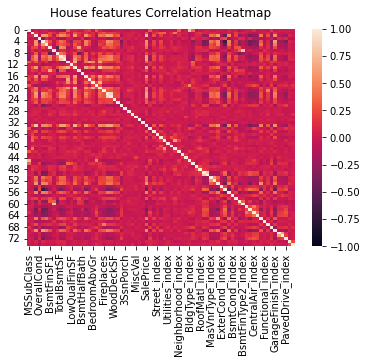

In [479]:
from os import truncate
from re import T
from pyspark.ml.linalg import DenseMatrix, Vectors
from pyspark.ml.stat import Correlation

corr_assem = VectorAssembler(inputCols=indexers_df.columns, outputCol='corr_features')
corr_vector = corr_assem.transform(indexers_df).select("corr_features")

pearsonCorr = Correlation.corr(corr_vector, 'corr_features', 'pearson').collect()[0][0]

corr_matrix = pearsonCorr.toArray().tolist()
corr_df = spark.createDataFrame(corr_matrix,indexers_df.columns)

heatmap = sns.heatmap(corr_df.toPandas(),vmin=-1, vmax=1)

heatmap.set_title('House features Correlation Heatmap', fontdict={'fontsize':12}, pad=12);

correlation_colums = [
    "GrLivArea",
"TotalBsmtSF",
"1stFlrSF",
"TotRmsAbvGrd",
"FullBath",
"BsmtFinSF1",
"GarageCars", 
"2ndFlrSF",
"GarageArea",
"LotArea",
"YearBuilt",
"LotFrontage_index",
"YearRemodAdd",
"BsmtQual_index",
"OpenPorchSF",
"BsmtUnfSF", 
"MoSold",
"OverallCond", 
"WoodDeckSF", 
"KitchenQual_index",
"ExterQual_index",
"GarageType_index",
"MSSubClass",
"BsmtFullBath",
"MSZoning_index",
"ScreenPorch", 
"YrSold",
"BsmtExposure_index",
"GarageFinish_index",
"MasVnrArea_index"
]

# SELECT ONLY CORRELATION FEAUTRES
indexers_df = indexers_df.select(correlation_colums)

indexers_df.describe().toPandas()



## Assembler

In [480]:
assem = VectorAssembler(inputCols=indexers_df.columns, outputCol='features')

## Pipeline

In [481]:

stages = [*indexers,assem]
pipeline = Pipeline(stages = stages)
final_data = pipeline.fit(sdf).transform(sdf)
final_data.select("features","SalePrice").show(5)


+--------------------+---------+
|            features|SalePrice|
+--------------------+---------+
|[1710.0,856.0,856...|   208500|
|[1262.0,1262.0,12...|   181500|
|[1786.0,920.0,920...|   223500|
|[1717.0,756.0,961...|   140000|
|[2198.0,1145.0,11...|   250000|
+--------------------+---------+
only showing top 5 rows



# Machine learning

## Split Test and Train dataset

In [482]:
train, test = final_data.cache().randomSplit([0.8, 0.2], seed=42)

print("train count:" ,train.count())
print("test count:" ,test.count())

train count: 1207
test count: 253


## Linear Regression

In [483]:
lr = LinearRegression(featuresCol="features",labelCol="SalePrice")

### Train section

In [484]:
train_model = lr.fit(train)
train_result = train_model.evaluate(train)

print("r2:",train_result.r2)
print("MSE:",train_result.meanSquaredError)

22/10/07 12:49:40 WARN Instrumentation: [2788f8b9] regParam is zero, which might cause numerical instability and overfitting.


r2: 0.7878630648774869
MSE: 1380652251.7223167


### Test section

In [485]:
from sklearn.metrics import mean_squared_error, r2_score
unlabeled_data = test.select("features")
test_result = train_model.evaluate(test)

print("r2:",test_result.r2)
print("MSE: ",test_result.meanSquaredError)


predictions = train_model.transform(unlabeled_data)
# print("meanAbsoluteError: ",mean_squared_error(predictions.select("SalePrice").collect(),predictions.select("prediction").collect()))

test.select("features","SalePrice").show(10)

predictions.toPandas()

r2: 0.8399261770536299
MSE:  855624945.8805966
+--------------------+---------+
|            features|SalePrice|
+--------------------+---------+
|[1262.0,1262.0,12...|   185000|
|[1478.0,1470.0,14...|   222000|
|[1314.0,1300.0,13...|   229456|
|[1766.0,1766.0,17...|   370878|
|[1425.0,1425.0,14...|   180500|
|[1902.0,1902.0,19...|   335000|
|[1523.0,1193.0,15...|   180000|
|[2076.0,2076.0,20...|   465000|
|[2084.0,2078.0,20...|   385000|
|[1328.0,1350.0,13...|   170000|
+--------------------+---------+
only showing top 10 rows



,features,prediction
0,"[1262.0, 1262.0, 1262.0, 5.0, 2.0, 905.0, 2.0,...",198994.736997
1,"[1478.0, 1470.0, 1478.0, 7.0, 2.0, 578.0, 2.0,...",257451.121694
2,"[1314.0, 1300.0, 1314.0, 6.0, 2.0, 936.0, 2.0,...",226812.279952
3,"[1766.0, 1766.0, 1766.0, 7.0, 2.0, 1121.0, 3.0...",319394.079807
4,"[1425.0, 1425.0, 1425.0, 7.0, 2.0, 490.0, 2.0,...",155489.371577
...,...,...
248,"[1699.0, 978.0, 1014.0, 7.0, 2.0, 440.0, 2.0, ...",160369.027636
249,"[1716.0, 780.0, 936.0, 9.0, 2.0, 210.0, 0.0, 7...",121449.977428
250,"[754.0, 520.0, 520.0, 5.0, 1.0, 490.0, 0.0, 0....",52647.918233
251,"[1889.0, 925.0, 964.0, 9.0, 1.0, 0.0, 1.0, 925...",138194.442248


## Generate regression line 

In [486]:


sns.regplot(data=predictions, x='prediction', y='features', ci=None)

Py4JJavaError: An error occurred while calling o55169.notEqual.
: java.lang.RuntimeException: Unsupported literal type class java.util.ArrayList [1]
	at org.apache.spark.sql.catalyst.expressions.Literal$.apply(literals.scala:90)
	at org.apache.spark.sql.catalyst.expressions.Literal$.$anonfun$create$2(literals.scala:152)
	at scala.util.Failure.getOrElse(Try.scala:222)
	at org.apache.spark.sql.catalyst.expressions.Literal$.create(literals.scala:152)
	at org.apache.spark.sql.functions$.typedLit(functions.scala:131)
	at org.apache.spark.sql.functions$.lit(functions.scala:114)
	at org.apache.spark.sql.Column.notEqual(Column.scala:353)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:566)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:238)
	at java.base/java.lang.Thread.run(Thread.java:829)
